In [1]:
import numpy as np
from skimage import io


class ImageParser:
    def __init__(self):
        pass

    @staticmethod
    def read_png(path):
        image = io.imread(path, as_gray=True)
        return np.add(image < 0.4, image < 0.8, dtype=int)

    @staticmethod
    def write_png(image, path):
        fib = [153, 1, 2]
        myo = [226, 168, 88]

        out_image = np.zeros((image.shape[0], image.shape[1], 3),
                             dtype=np.uint8)
        out_image[image == 1] = myo
        out_image[image == 2] = fib
        io.imsave(path, out_image)


4


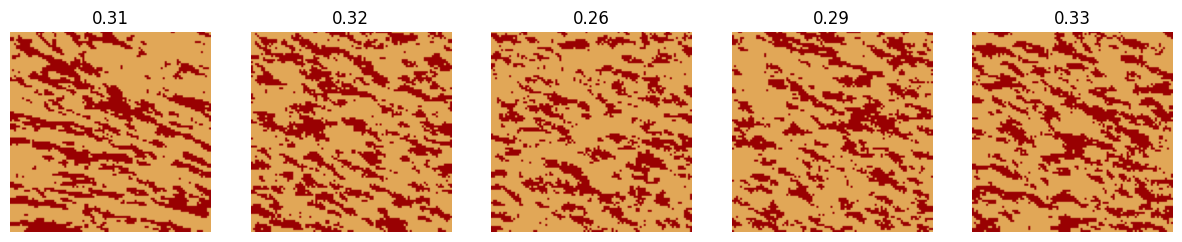

In [43]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

tex_cmap = mcolors.LinearSegmentedColormap.from_list(
    'fibrosis', [(0, '#e2a858'),
                 (0.5, '#e2a858'),
                 (1, '#990102')])

path = Path('/Users/arstanbek/Projects/BiTis/data')

j = 11
tr_filename = f'or_tex_{j}.png'
tr_image = ImageParser.read_png(path.joinpath('training', tr_filename))
tr_image = tr_image[0:100, 0:100]
tr_image[tr_image == 0] = 1

img = []
dens = []
inds = np.random.choice(np.arange(50), 4, replace=False)

for i in inds:
    image = ImageParser.read_png(path.joinpath('simulated_100',
                                               f'gen_tex_{j}_{i}.png'))
    img.append(image)
    dens.append(np.mean(image == 2))

print(len(img))

fig, axs = plt.subplots(1, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flat):
    if i == 0:
        ax.imshow(tr_image, vmin=0, vmax=2, cmap=tex_cmap)
        ax.axis('off')
        ax.set_title(f'{np.mean(tr_image == 2):.2f}')
        continue
    ax.imshow(img[i - 1], vmin=0, vmax=2, cmap=tex_cmap)
    ax.axis('off')
    ax.set_title(f'{dens[i - 1]:.2f}')
plt.show()

In [62]:
from bitis.texture.texture import Texture
from bitis.texture.properties import (
    PatternPropertiesBuilder,
    DistributionEllipseBuilder,
    PolarPlots,
    PointDensity
)


def calc_props(image):
    pattern_builder = PatternPropertiesBuilder(area_quantile=0.95,
                                               area_min=5)
    pattern_properties = pattern_builder.build(image == 2)

    texture = Texture()
    texture.matrix = image
    texture.properties["pattern"] = pattern_properties
    texture.properties["object_props"] = pattern_builder.object_props
    return texture


def read_image(path):
    image = ImageParser.read_png(path)
    image[image == 0] = 1
    return image[:100, :100]


path = Path('/Users/arstanbek/Projects/BiTis/data/simulated_100_20_30')
textures = [calc_props(read_image(path.joinpath(f'gen_tex_11_{i}.png'))) for i in range(100)]

In [63]:
path = Path('/Users/arstanbek/Projects/BiTis/data/training')
training_texture = calc_props(read_image(path.joinpath('or_tex_11.png')))

Training density: 0.306
Mean density: 0.306


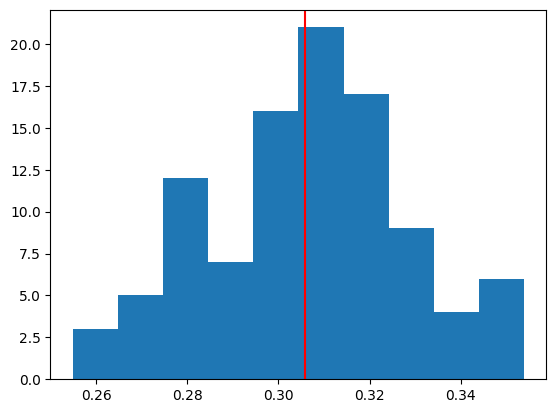

In [64]:
densities = [np.mean(texture.matrix == 2) for texture in textures]
tr_density = np.mean(training_texture.matrix == 2)

print(f'Training density: {tr_density:.3f}')
print(f'Mean density: {np.mean(densities):.3f}')


plt.figure()
plt.hist(densities, bins=10)
plt.axvline(tr_density, color='red')
plt.show()

In [65]:
uniform_image = np.random.random(training_texture.matrix.shape) < tr_density
uniform_image = uniform_image.astype(int) + 1
uniform_texture = calc_props(uniform_image)

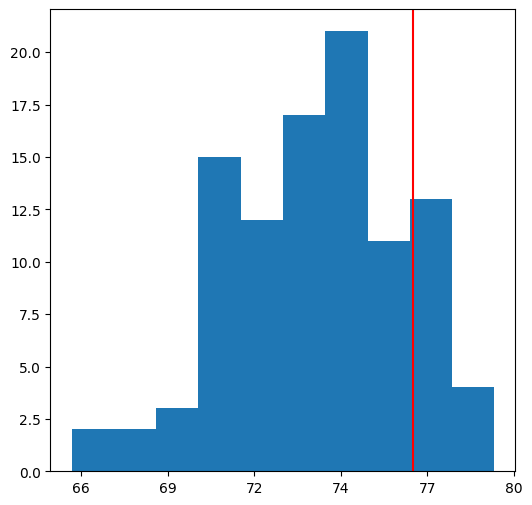

In [66]:
orientations = [tex.properties["pattern"].orientation.values for tex in textures]
orientations = np.concatenate(orientations)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(orientations)
ax.axvline(training_texture.properties["pattern"].orientation.values, color='red')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{np.degrees(x):.0f}'))
plt.show()

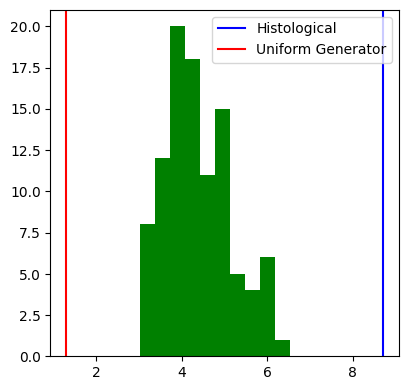

In [67]:
sa = [tex.properties["pattern"].structural_anisotropy.values for tex in textures]
sa = np.concatenate(sa)

plt.figure(figsize=(4.5, 4.5))
plt.hist(sa, color='green')
plt.axvline(training_texture.properties["pattern"].structural_anisotropy.values,
            color='blue', label='Histological')
plt.axvline(uniform_texture.properties["pattern"].structural_anisotropy.values,
            color='red', label='Uniform Generator')
plt.legend()
plt.show()

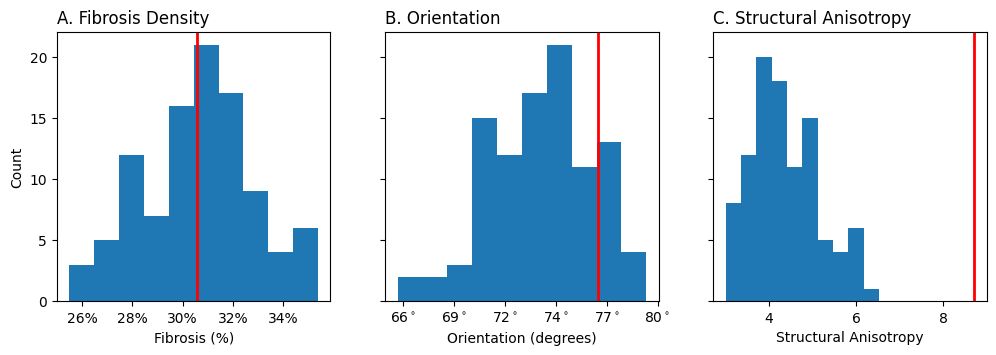

In [77]:
import matplotlib as mpl


fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), sharey=True)
axs[0].hist(densities, bins=10, color='tab:blue')
axs[0].axvline(tr_density, color='red', lw=2)
axs[0].set_title('A. Fibrosis Density', fontsize=12, loc='left')
axs[0].xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
axs[0].set_xlabel('Fibrosis (%)', fontsize=10)
axs[0].set_yticks(np.arange(0, 22, 5))
axs[0].set_ylabel('Count', fontsize=10)

axs[1].hist(orientations, bins=10, color='tab:blue')
axs[1].axvline(training_texture.properties["pattern"].orientation.values,
               color='red', lw=2)
axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{np.degrees(x):.0f}$^\circ$'))
axs[1].set_title('B. Orientation', fontsize=12, loc='left')
axs[1].set_xlabel('Orientation (degrees)', fontsize=10)

axs[2].hist(sa, color='tab:blue')
axs[2].axvline(training_texture.properties["pattern"].structural_anisotropy.values,
               color='red', label='Histological', lw=2)
axs[2].set_title('C. Structural Anisotropy', fontsize=12, loc='left')
axs[2].set_xlabel('Structural Anisotropy', fontsize=10)
# axs[2].set_xlim(1, 10)
plt.show()

In [78]:
fig.savefig('ds_generation_quality.png', dpi=300, bbox_inches='tight')

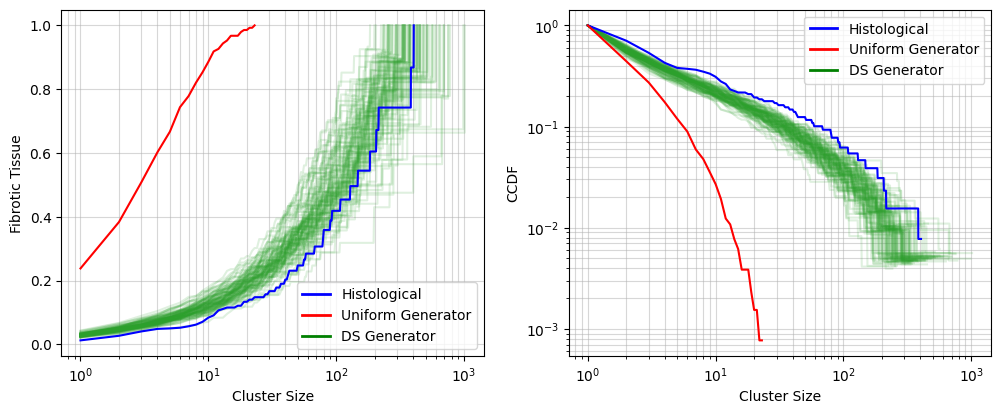

In [73]:
def calc_ccdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(ax, objects_props, label='', color='blue', alpha=1.0):
    area_bins, cdf = calc_area_cdf(objects_props)
    ax.plot(area_bins, cdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Fibrotic Tissue')
    ax.set_xscale('log')


def draw_ccdf(ax, objects_props, label='', color='blue', alpha=1.0):
    area_bins, ccdf = calc_ccdf(objects_props)
    ax.plot(area_bins, ccdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('CCDF')
    ax.set_yscale('log')
    ax.set_xscale('log')


fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))
for texture in textures:
    draw_area_cdf(axs[0], texture.properties["object_props"],
                  color='tab:green', alpha=0.15)
    draw_ccdf(axs[1], texture.properties["object_props"],
              color='tab:green', alpha=0.15)
draw_area_cdf(axs[0], training_texture.properties["object_props"],
              label='Histological', color='blue')
draw_ccdf(axs[1], training_texture.properties["object_props"],
          label='Histological', color='blue')
draw_area_cdf(axs[0], uniform_texture.properties["object_props"],
              label='Uniform Generator', color='red')
draw_ccdf(axs[1], uniform_texture.properties["object_props"],
          label='Uniform Generator', color='red')

axs[0].legend(handles=[plt.Line2D([0], [0], color='blue', lw=2),
                       plt.Line2D([0], [0], color='red', lw=2),
                       plt.Line2D([0], [0], color='green', lw=2)],
              labels=('Histological', 'Uniform Generator', 'DS Generator'),
              loc='lower right')
axs[1].legend(handles=[plt.Line2D([0], [0], color='blue', lw=2),
                       plt.Line2D([0], [0], color='red', lw=2),
                       plt.Line2D([0], [0], color='green', lw=2)],
              labels=('Histological', 'Uniform Generator', 'DS Generator'),
              loc='upper right')
axs[0].grid(True, which='both', alpha=0.5)
axs[1].grid(True, which='both', alpha=0.5)
plt.show()

In [75]:
fig.savefig('ds_generation_quality_size.png', dpi=300, bbox_inches='tight')